# Q2: Contrastive Language-Image Pretraining [6 points]

## 1. [1 point] Setup models.

In [1]:
import os
import torch
import clip 
import torchvision.models as models
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# ImageNet pretraining
resnet50_imagenet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1).to(device)
# OpenAI's CLIP
clip_model, preprocess = clip.load("RN50", device=device)
clip_image_encoder = clip_model.visual.to(device)

In [3]:
file_path = 'classes.json'
with open(file_path, 'r') as json_file:
    IMAGENET2012_CLASSES = json.load(json_file)
# List of ImageNet classes (1000 categories)
imagenet_classes=list(IMAGENET2012_CLASSES.values())

The ImageNet-pretrained ResNet-50 has weights trained for image classification on the ImageNet dataset. The vision encoder in CLIP is based on a modified ResNet architecture (ResNet-50x4) compared to the standard ResNet-50. This modification involves scaling up the ResNet-50 architecture to a larger scale (4 times) to enhance its visual understanding capability for the CLIP task.The CLIP model's visual encoder, however, has been further trained on a large dataset of image-text pairs. This additional training allows the CLIP encoder to learn features that are not only good for classification but also for understanding the semantic relationship between images and text.

## 2. [1 point] Setup data. Understand the ImageNet challenge dataset

The ImageNet challenge dataset uses the WordNet hierarchy for organizing its 1000 labels (also called synsets) associated with ILSVRC.

**(i) Label Hierarchy (WordNet):**

* WordNet is a lexical database that groups words into synonym sets (synsets) and connects them through defined relationships like "is-a," "part-of," etc.
* ImageNet leverages this hierarchy by assigning each synset a unique label and using the WordNet structure to organize related concepts.

**(ii) What is a Synset?**

* A synset is a group of words or phrases that share the same meaning. In ImageNet, it represents a category of objects within the 1000 labels.
* For example, the synset "n01532825" might correspond to the label "golden retriever."

**(iii) Problems with Grouping by Synsets for Visual Recognition?**

* Yes, grouping objects based on synsets can lead to challenges for visual recognition tasks. Here's why:
    * **Intra-class Variability:** Synsets can encompass objects with significant visual differences. A synset for "dog" might include images of golden retrievers, poodles, chihuahuas, etc. These breeds have distinct appearances that a model needs to learn.
    * **Background Clutter:** Images within a synset might vary considerably due to background clutter. A "chair" synset could have images of chairs in different rooms, with different objects around them. The model needs to focus on the chair itself despite these variations.
    * **Pose and Viewpoint:** Objects within a synset can appear in various poses and viewpoints. A "car" synset could have images of cars from the front, side, or back. The model needs to be robust to these pose variations.


**(iv) 3 Types of Visual Differences in Images with the Same Synset:**

1. **Object Appearance:** As mentioned earlier, objects within a synset can have significant visual differences in terms of breed, shape, size, color, or material.
2. **Background Complexity:** Images can vary in background complexity, with objects appearing in cluttered environments, outdoors, or with other objects around them.
3. **Pose and Viewpoint:** The pose and viewpoint of the object can differ significantly within a synset. Objects can be tilted, rotated, or partially occluded, requiring the model to recognize them from various perspectives.


In [4]:
# Function to perform zero-shot classification with CLIP
def zero_shot_clip(image_path,text_features,flag=False):

    # Extracting Image features
    with open(image_path, "rb") as f:
        image = Image.open(f).convert("RGB")
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image)
    
    logits_per_image = torch.cosine_similarity(image_features, text_features, dim=-1)
    probs = torch.softmax(logits_per_image, dim=-1)
    
    # Get top predicted classes and corresponding probabilities
    top_probabilities, top_indices = torch.topk(probs, k=5, dim=0)
    top_classes = [imagenet_classes[idx] for idx in top_indices]
    if flag:
        return top_probabilities
    return top_classes

In [5]:
def get_resnet_top5_categories(image_path):
    
    resnet50_imagenet.eval()
    with torch.no_grad():
        image_tensor = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
        resnet_features = resnet50_imagenet(image_tensor)
    
    # Compute probability scores for ResNet-50
    resnet_probs = torch.softmax(resnet_features, dim=1)
    resnet_top5_indices = torch.topk(resnet_probs[0], k=5).indices.tolist()
    resnet_top5_classes = [imagenet_classes[idx] for idx in resnet_top5_indices]
    return resnet_top5_classes

In [6]:
# Text prompt for zero-shot classification
text_prompt = "a photo of a {}"
text_features=[]
with torch.no_grad():
    for label in tqdm(imagenet_classes):
        label = text_prompt.format(label)
        text = clip.tokenize([label]).to(device)
        curr_features = clip_model.encode_text(text)
        text_features.append(curr_features)
text_features = torch.cat(text_features, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 111.00it/s]


In [7]:
# Example images and corresponding text prompts
example_images = os.listdir("random_examples")
example_image_paths = [os.path.join("./random_examples",image_path) for image_path in example_images  if image_path[0] != "."]

In [8]:
for image_path in example_image_paths:
    top_classes = zero_shot_clip(image_path,text_features)
    print(f"Top predicted ImageNet classes for {image_path.split('/')[-1]}:\n")
    for class_ in top_classes:
        print("-->",class_)
    print("="*50)

Top predicted ImageNet classes for cat.jpeg:

--> tabby, tabby cat
--> tiger cat
--> Egyptian cat
--> Persian cat
--> cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
Top predicted ImageNet classes for dog-puppy.jpg:

--> Labrador retriever
--> golden retriever
--> cocker spaniel, English cocker spaniel, cocker
--> Japanese spaniel
--> soft-coated wheaten terrier
Top predicted ImageNet classes for house.jpeg:

--> mobile home, manufactured home
--> web site, website, internet site, site
--> tile roof
--> recreational vehicle, RV, R.V.
--> cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM
Top predicted ImageNet classes for box_turtle_1.jpg:

--> terrapin
--> box turtle, box tortoise
--> leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea
--> mud turtle
--> loggerhead, loggerhead turtle, Caretta caretta
Top predicted ImageNet classes for alligator_2.jpg:

--> American alliga

## 4. [1.5 points] CLIP vs ImageNet pretraining.

In [9]:
example_images = os.listdir("images_examples")
example_image_paths = sorted([os.path.join("./images_examples",image_path) for image_path in example_images if image_path[0] != "."])

In [10]:
classes = []
i=0;
for image in example_image_paths:
    if i%3 ==0:
        classes.append(image.split("/")[-1][:-6])
    i+=1
classes

['alligator',
 'box_turtle',
 'cockatoo',
 'croc_clip',
 'eagle',
 'frilled_lizard',
 'frog',
 'scorpion',
 'ship',
 'spider']

In [11]:
for class_ in classes:
    print("_"*150)
    print(class_)
    print("_"*150)
    for i in range(1,4):
        print(f"--> {class_}_{i}.jpg")
        print("--CLIP--")
        image_path = os.path.join("./images_examples",f"{class_}_{i}.jpg")
        top_classes= zero_shot_clip(image_path,text_features)
        print(top_classes)

        print("--Resnet--")
        top_classes = get_resnet_top5_categories(image_path)
        print(top_classes)
        print("-"*75)

______________________________________________________________________________________________________________________________________________________
alligator
______________________________________________________________________________________________________________________________________________________
--> alligator_1.jpg
--CLIP--
['triceratops', 'American alligator, Alligator mississipiensis', 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis', 'alligator lizard', 'common iguana, iguana, Iguana iguana']
--Resnet--
['comic book', 'jersey, T-shirt, tee shirt', 'puck, hockey puck', 'flatworm, platyhelminth', 'zebra']
---------------------------------------------------------------------------
--> alligator_2.jpg
--CLIP--
['American alligator, Alligator mississipiensis', 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis', 'American chameleon, anole, Anolis carolinensis', 'African crocodile, Nile crocodile, Crocodylus nilot

In [12]:
example_images = os.listdir("resnet_better_than_clip")
example_image_paths = sorted([os.path.join("./resnet_better_than_clip",image_path) for image_path in example_images if image_path[0] != "."])

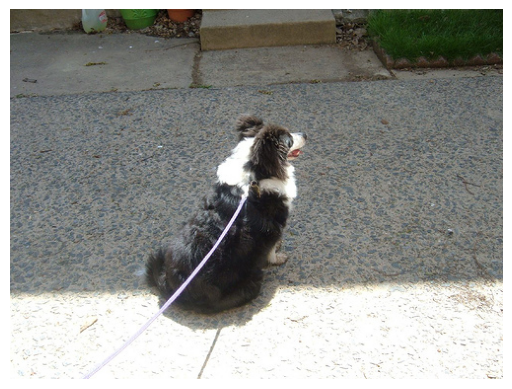

--CLIP--
['Blenheim spaniel', 'cocker spaniel, English cocker spaniel, cocker', 'English springer, English springer spaniel', 'Border collie', 'Japanese spaniel']
--Resnet--
['Shetland sheepdog, Shetland sheep dog, Shetland', 'Old English sheepdog, bobtail', 'Border collie', 'Bernese mountain dog', 'collie']
---------------------------------------------------------------------------


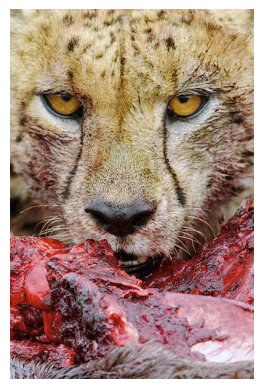

--CLIP--
['cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'lynx, catamount', 'snow leopard, ounce, Panthera uncia', 'jaguar, panther, Panthera onca, Felis onca', 'lion, king of beasts, Panthera leo']
--Resnet--
['cheetah, chetah, Acinonyx jubatus', 'lynx, catamount', 'lion, king of beasts, Panthera leo', 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor', 'jaguar, panther, Panthera onca, Felis onca']
---------------------------------------------------------------------------


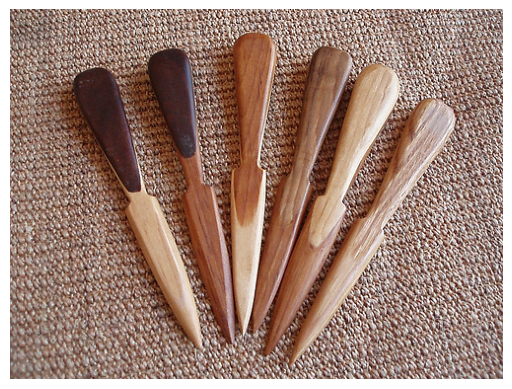

--CLIP--
['panpipe, pandean pipe, syrinx', 'wooden spoon', "carpenter's kit, tool kit", 'spatula', 'clog, geta, patten, sabot']
--Resnet--
['letter opener, paper knife, paperknife', 'wooden spoon', 'drumstick', 'quill, quill pen', 'ballpoint, ballpoint pen, ballpen, Biro']
---------------------------------------------------------------------------


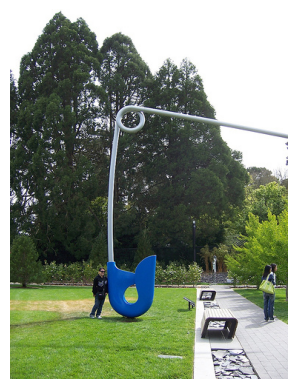

--CLIP--
['swing', 'gondola', 'unicycle, monocycle', 'harp', 'pole']
--Resnet--
['safety pin', 'hook, claw', 'horizontal bar, high bar', 'trombone', 'swing']
---------------------------------------------------------------------------


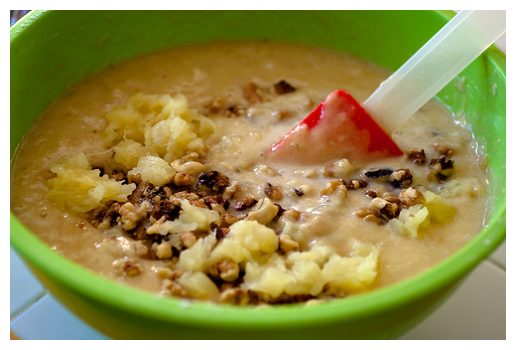

--CLIP--
['consomme', 'trifle', 'potpie', 'soup bowl', 'eggnog']
--Resnet--
['soup bowl', 'wooden spoon', 'mixing bowl', 'spatula', 'mashed potato']
---------------------------------------------------------------------------


In [13]:
for image_path in example_image_paths:

    image = Image.open(image_path).convert("RGB")
    plt.figure()
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    print("--CLIP--")
    top_classes = zero_shot_clip(image_path,text_features)
    print(top_classes)

    print("--Resnet--")
    top_classes = get_resnet_top5_categories(image_path)
    print(top_classes)
    print("-"*75)

### ImageNet Pretraining Struggles:

- **Limited Label Hierarchy:**
  - Struggles with objects that don't fit neatly into predefined synsets or hierarchical categories.

- **Handling Variability in Object Appearances:**
  - Faces challenges with images containing objects that deviate significantly from typical representations within a synset.

- **Interpreting Context and Composition:**
  - Difficulty in understanding objects within diverse contexts or complex compositions, impacting recognition accuracy.

### CLIP Model Limitations:

- **Semantic Generalization Challenges:**
  - May struggle with abstract or novel concepts not explicitly represented in the training data.

- **Interpreting Fine-grained Visual Details:**
  - Can have difficulty capturing fine-grained visual details compared to models specifically trained for image recognition.

## 5. [1.5 points] FP16.

### (i) Time taken to encode Image

In [1]:
import torch
import clip 
import numpy as np
from PIL import Image
import time

clip_model, preprocess = clip.load("RN50", device='cuda')
image_encoder_fp32 = clip_model.visual

clip_model1, preprocess = clip.load("RN50", device='cuda')
image_encoder_fp16 = clip_model1.visual.half()

def measure_encoding_time(image_encoder, image, runs=100):
    times = []
    for _ in range(runs):
        start_time = time.time()
        with torch.no_grad():
            _ = image_encoder(image)
        end_time = time.time()
        elapsed_time = end_time - start_time
        times.append(elapsed_time)
    mean_time = np.mean(times)
    std_dev_time = np.std(times)
    return mean_time, std_dev_time

example_image = Image.open("./random_examples/cat.jpeg")
input_image = preprocess(example_image).unsqueeze(0).to('cuda')
torch.cuda.empty_cache()
image_encoder_fp32.to(torch.float32)
mean_fp32, std_dev_fp32 = measure_encoding_time(image_encoder_fp32, input_image)
torch.cuda.empty_cache()
image_encoder_fp16.to(torch.float16)
mean_fp16, std_dev_fp16 = measure_encoding_time(image_encoder_fp16, input_image.to(torch.float16))

print(f"FP32 encoding time: Mean = {mean_fp32:.6f} s, Std Dev = {std_dev_fp32:.6f} s")
print(f"FP16 encoding time: Mean = {mean_fp16:.6f} s, Std Dev = {std_dev_fp16:.6f} s")

FP32 encoding time: Mean = 0.028859 s, Std Dev = 0.223577 s
FP16 encoding time: Mean = 0.008212 s, Std Dev = 0.009230 s


In [15]:
def compute_probability_scores(image_features,text_features):
    with torch.no_grad():
        logits_per_image = torch.cosine_similarity(image_features, text_features, dim=-1)
        probs = torch.softmax(logits_per_image, dim=-1)
    return probs

In [16]:
import os
# Example images and corresponding text prompts
example_images = os.listdir("random_examples")
example_image_paths = [os.path.join("./random_examples",image_path) for image_path in example_images  if image_path[0] != "."]

In [17]:
import json
file_path = 'classes.json'
with open(file_path, 'r') as json_file:
    IMAGENET2012_CLASSES = json.load(json_file)
# List of ImageNet classes (1000 categories)
imagenet_classes=list(IMAGENET2012_CLASSES.values())

In [18]:
from tqdm import tqdm
import torch
import clip 

clip_model, preprocess = clip.load("RN50", device='cuda')
image_encoder_fp32 = clip_model.visual

# Text prompt for zero-shot classification
text_prompt = "a photo of a {}"
text_features=[]
with torch.no_grad():
    for label in tqdm(imagenet_classes):
        label = text_prompt.format(label)
        text = clip.tokenize([label]).to('cuda')
        curr_features = clip_model.encode_text(text)
        text_features.append(curr_features)
text_features = torch.cat(text_features, dim=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 125.43it/s]


In [19]:
from PIL import Image

probs_fp32=[]
for image_path in example_image_paths:
    example_image = Image.open(image_path)
    input_image = preprocess(example_image).unsqueeze(0).to('cuda')
    with torch.no_grad():
        image_encoder_fp32.to(torch.float32)
        image_features_fp32 = image_encoder_fp32(input_image)
    probs_fp32 .append(compute_probability_scores(image_features_fp32,text_features))

In [20]:
from tqdm import tqdm
import clip 
import torch

clip_model, preprocess = clip.load("RN50", device='cuda')
image_encoder_fp16 = clip_model.visual.half()
# Text prompt for zero-shot classification
text_prompt = "a photo of a {}"
text_features=[]
with torch.no_grad():
    for label in tqdm(imagenet_classes):
        label = text_prompt.format(label)
        text = clip.tokenize([label]).to('cuda')
        curr_features = clip_model.encode_text(text)
        text_features.append(curr_features)
text_features = torch.cat(text_features, dim=0).half()

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.74it/s]


In [21]:
from PIL import Image

probs_fp16=[]
for image_path in example_image_paths:
    example_image = Image.open(image_path)
    input_image = preprocess(example_image).unsqueeze(0).to('cuda')
    with torch.no_grad():
        image_features_fp16 = image_encoder_fp16(input_image.half())
    probs_fp16.append(compute_probability_scores(image_features_fp16,text_features))

In [22]:
differences=0
i=0
for image_path in example_image_paths:
    diff = torch.sum(torch.abs(probs_fp32[i]-probs_fp16[i]))
    differences += diff.cpu().numpy()
    i+=1
print(differences/5)

0.00023591407807543874


## Observations

**Inference Speed and Memory Efficiency Favor FP16**

While the output probabilities show minimal difference (mean absolute difference of 0.0002) between FP16 and FP32 models, there are significant advantages in terms of inference speed and memory usage when using FP16:

* **Memory Usage:** The FP16 model consumes considerably less memory compared to the FP32 model (`1242MB` vs. `1734MB`). This represents a reduction of nearly 30% in memory footprint.
* **Inference Time:** The FP16 model exhibits a faster encoding time (`0.008 s`) compared to the FP32 model (`0.02 s`). This translates to a speedup of roughly 2.5 times.

**Prioritizing Speed and Efficiency? Choose FP16**

Given the minimal impact on output probabilities and the substantial gains in inference speed and memory usage, the FP16 model appears to be a more efficient choice for this task, particularly if these aspects are critical considerations.

#### Below is the memory usage for fp 16 model
![fp16](fp16.png)
#### Below is the meory usage for fp 32 model
![fp32](fp32.png)